# Trabalho Prático II - Part-of-Speech Tagging

## Vinícius Alexandre da Silva

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, Bidirectional, LSTM, Embedding
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from pathlib import Path

2025-01-20 16:34:04.952088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 16:34:09.332947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-20 16:34:09.332992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-20 16:34:09.758710: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 16:34:18.870325: W tensorflow/stream_executor/platform/de

# Pré-Processamento

Primeiramente abre os arquivos de entrada do corpus para criar 3 listas de palavras e listas de tags correspondentes.

In [ ]:
def build_sentence(filename):
    """
    Lê um arquivo contendo palavras etiquetadas e constrói uma lista de sentenças.

    Cada linha no arquivo deve conter palavras com suas respectivas etiquetas,
    separadas por sublinhados (por exemplo, "palavra_etiqueta"). A função divide
    cada linha em palavras, separa as palavras de suas etiquetas e constrói
    uma lista de sentenças onde cada sentença é uma lista de tuplas (palavra, etiqueta).

    Args:
        filename (str): O nome do arquivo a ser lido. O arquivo deve estar
                        localizado no diretório "data/".

    Returns:
        tuple: Uma tupla contendo duas listas:
           - A primeira lista contém sentenças, onde cada sentença é uma lista de palavras.
           - A segunda lista contém sentenças, onde cada sentença é uma lista de etiquetas.
    """
    path = "data/"
    words, tags = [], []
    with open(path + filename, "r") as f:
        corpus = f.readlines()
        for sentence in corpus:
            sentence_words, sentence_tags = [], []

            for token in sentence.split():
                token = token.split(sep="_")
                sentence_words.append(token[0])
                sentence_tags.append(token[1])

            words.append(sentence_words)
            tags.append(sentence_tags)

    return words, tags


X_train, y_train = build_sentence("macmorpho-train.txt")
X_test, y_test = build_sentence("macmorpho-test.txt")
X_val, y_val = build_sentence("macmorpho-dev.txt")

print(f"Número de sentenças em Train: {len(X_train)}")
print(f"Número de sentenças em Test:  {len(X_test)}")
print(f"Número de sentenças em Valid: {len(X_val)}")

Número de sentenças em Train: 37948
Número de sentenças em Test:  9987
Número de sentenças em Valid: 1997


`X` tem o formato de lista de lista de palavras, sendo as listas internas para cada sentença.
`y` tem o mesmo formato para os tags.

In [4]:
maxlen_train = max(len(sent) for sent in X_train)
maxlen_test = max(len(sent) for sent in X_test)
maxlen_val = max(len(sent) for sent in X_val)

max_sequence_length = max((maxlen_train, maxlen_test, maxlen_val))
print(f"Frase com maior tamanho: {max_sequence_length} tokens")

Frase com maior tamanho: 248 tokens


## Tokenizer

Converte todas palavras e pontuações em tokens, mantém maiúsculas para identificação de nomes próprios.

Cria um vetor para cada frase passando o índice de cada token na posição correspondente na frase.

In [5]:
word_tokenizer = Tokenizer(
    num_words=None,
    lower=False,
    oov_token="UNK",
    filters="#$%&*+-/<=>@[\\]^_`{|}~\t\n",
)

# Vocabulário criado somente a partir dos dados de treino para não ter vazamento
word_tokenizer.fit_on_texts(X_train)
X_train_int = word_tokenizer.texts_to_sequences(X_train)
X_test_int = word_tokenizer.texts_to_sequences(X_test)
X_val_int = word_tokenizer.texts_to_sequences(X_val)

Cria um token `UNK` para representar palavras desconhecidas do vocabulário.

In [6]:
print("Formato de um vetor de sentenças:")
print(X_train_int[0])

Formato de um vetor de sentenças:
[18938, 3189, 177, 4, 135, 6764, 695, 22, 355, 11, 12207, 12, 43, 46, 3]


In [7]:
word2index = word_tokenizer.word_index
vocab_size = len(word2index)
print(f"Vocabulário contém {vocab_size} palavras únicas.")

Vocabulário contém 52760 palavras únicas.


In [8]:
print("Formato do vocabulário:")
print(list(word2index.items())[:25])

Formato do vocabulário:
[('UNK', 1), (',', 2), ('.', 3), ('de', 4), ('a', 5), ('o', 6), ('e', 7), ('"', 8), ('que', 9), ('do', 10), ('da', 11), ('em', 12), ('para', 13), ('com', 14), ('no', 15), ('um', 16), (')', 17), ('(', 18), ('O', 19), ('é', 20), ('os', 21), ('na', 22), ('A', 23), ('uma', 24), ('não', 25)]


Mostrando todos os conjuntos de dados contêm todos os tags.

In [ ]:
all_targets_train = {x for l in y_train for x in l}
all_targets_test = {x for l in y_test for x in l}
all_targets_val = {x for l in y_val for x in l}

print(sorted(all_targets_train))
print(sorted(all_targets_test))
print(sorted(all_targets_val))

['ADJ', 'ADV', 'ADV-KS', 'ART', 'CUR', 'IN', 'KC', 'KS', 'N', 'NPROP', 'NUM', 'PCP', 'PDEN', 'PREP', 'PREP+ADV', 'PREP+ART', 'PREP+PRO-KS', 'PREP+PROADJ', 'PREP+PROPESS', 'PREP+PROSUB', 'PRO-KS', 'PROADJ', 'PROPESS', 'PROSUB', 'PU', 'V']
['ADJ', 'ADV', 'ADV-KS', 'ART', 'CUR', 'IN', 'KC', 'KS', 'N', 'NPROP', 'NUM', 'PCP', 'PDEN', 'PREP', 'PREP+ADV', 'PREP+ART', 'PREP+PRO-KS', 'PREP+PROADJ', 'PREP+PROPESS', 'PREP+PROSUB', 'PRO-KS', 'PROADJ', 'PROPESS', 'PROSUB', 'PU', 'V']
['ADJ', 'ADV', 'ADV-KS', 'ART', 'CUR', 'IN', 'KC', 'KS', 'N', 'NPROP', 'NUM', 'PCP', 'PDEN', 'PREP', 'PREP+ADV', 'PREP+ART', 'PREP+PRO-KS', 'PREP+PROADJ', 'PREP+PROPESS', 'PREP+PROSUB', 'PRO-KS', 'PROADJ', 'PROPESS', 'PROSUB', 'PU', 'V']


In [10]:
len(all_targets_test), len(all_targets_test), len(all_targets_val)

(26, 26, 26)

Também faz a tokenização dos tags, também salvando o vetor sem aumentar para o maior tamanho de sentença.

In [11]:
tag_tokenizer = Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(y_train)

y_train_int = tag_tokenizer.texts_to_sequences(y_train)
y_test_int = tag_tokenizer.texts_to_sequences(y_test)
y_val_int = tag_tokenizer.texts_to_sequences(y_val)

y_train_int_unpadded = y_train_int
y_test_int_unpadded = y_test_int
y_val_int_unpadded = y_val_int

In [12]:
tag2index = tag_tokenizer.word_index
print(f"Classes: {tag2index}")

Classes: {'N': 1, 'PU': 2, 'V': 3, 'NPROP': 4, 'PREP': 5, 'ART': 6, 'PREP+ART': 7, 'ADJ': 8, 'ADV': 9, 'KC': 10, 'PCP': 11, 'NUM': 12, 'PROADJ': 13, 'KS': 14, 'PRO-KS': 15, 'PROPESS': 16, 'PROSUB': 17, 'PDEN': 18, 'CUR': 19, 'PREP+PROADJ': 20, 'ADV-KS': 21, 'PREP+PROSUB': 22, 'PREP+PROPESS': 23, 'IN': 24, 'PREP+PRO-KS': 25, 'PREP+ADV': 26}


In [13]:
X_test[0], y_test[0], y_test_int_unpadded[0]

(['Salto', 'sete'], ['N', 'ADJ'], [1, 8])

Aumenta todos os vetores para o maior tamanho de sentença, para que todos os dados tenham a mesma dimensão.

In [16]:
X_train_int = pad_sequences(X_train_int, maxlen=max_sequence_length)
print(f"Shape of X_train: {X_train_int.shape}")

X_test_int = pad_sequences(X_test_int, maxlen=max_sequence_length)
print(f"Shape of X_test:  {X_test_int.shape}")

X_val_int = pad_sequences(X_val_int, maxlen=max_sequence_length)
print(f"Shape of X_val:   {X_val_int.shape}")
print()

y_train_int = pad_sequences(y_train_int, maxlen=max_sequence_length)
print(f"Shape of y_train: {y_train_int.shape}")

y_test_int = pad_sequences(y_test_int, maxlen=max_sequence_length)
print(f"Shape of y_test:  {y_test_int.shape}")

y_val_int = pad_sequences(y_val_int, maxlen=max_sequence_length)
print(f"Shape of y_val:   {y_val_int.shape}")

Shape of X_train: (37948, 248)
Shape of X_test:  (9987, 248)
Shape of X_val:   (1997, 248)

Shape of y_train: (37948, 248)
Shape of y_test:  (9987, 248)
Shape of y_val:   (1997, 248)


In [17]:
# Número de classes é o número de tags + tag de desconhecido
num_classes = len(all_targets_train) + 1
print(f"Número de classes: {num_classes}")

Número de classes: 27


# Modelo

## Bidirectional Long Short-Term Memory (BLSTM)

Long short-term memory (LSTM) faz uso de memórias de curto e longo prazos para que a RNN lembra-se por maior tempo entradas passadas.

Quando se tem uma estrutura sequencial, como texto, ter informações tanto da esquerda (passado) e da direita (futuro) da sequência pode ser vantajoso. Como a LSTM conhece apenas informações do passado, a sua versão Bidirecional (BLSTM) se mostra como uma solução para esse problema.

A ideia é computar a sequência de frente para trás e de trás para frente, para usar informações passadas e futuras.

![BLSTM](BLSTM.png)

Exemplo de uma arquitetura LSTM Bidirecional

In [22]:
def build_model(
    input_dim,
    vocab_size,
    embedding_dim,
    lstm_units,
    num_classes,
    dropout=0.1,
):
    """
    Constrói e compila um modelo LSTM Bidirecional para classificação de texto.

    Args:
        input_dim (int): A dimensão de entrada (comprimento das sequências de entrada).
        vocab_size (int): O tamanho do vocabulário.
        embedding_dim (int): A dimensão da camada de embedding.
        lstm_units (int): O número de unidades na camada LSTM.
        num_classes (int): O número de classes de saída.
        dropout (float, opcional): A taxa de dropout para a camada LSTM. O padrão é 0.1.

    Returns:
        keras.Model: O modelo Keras compilado.
    """
    # Camada de entrada
    i = Input(shape=(input_dim,))

    # Camada de embedding para converter sequências de entrada em vetores densos
    x = Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim)(i)

    # Camada Bidirecional LSTM
    x = Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout))(x)

    # Camada de saída Softmax
    x = Dense(num_classes, activation="softmax")(x)

    # Define a arquitetura do modelo
    model = Model(i, x)
    model.compile(
        loss=SparseCategoricalCrossentropy(),
        optimizer="adam",
        metrics=["accuracy"],
    )
    model.summary()
    return model

# Treino

Tem-se 18 combinações de modelos a serem treinados, conforme os 3 hiper-parâmetros:

* `Embedding Dim`: O tamanho do embedding a ser criado;
* `LSTM Units`: O número de células da camada LSTM, como é Bidirecional, o número final é o seu dobro;
* `Dropout`: Porcentagem de células que são desligadas a cada época para a regularização.

In [23]:
# Construção do modelo com os hiper-parâmteros a seguir:
# Melhor resultado encontrado e todas as combinações comentadas
emb_dims = [200]    # [50, 100, 200]
lstm_units = [64]   # [32, 64]
dropouts = [0.1]    # [0, 0.1, 0.2]
hist = []
for emb in emb_dims:
    for l in lstm_units:
        for d in dropouts:
            # Criação do modelo
            model_params = {
                "input_dim": max_sequence_length,
                "vocab_size": vocab_size,
                "embedding_dim": emb,
                "lstm_units": l,
                "num_classes": num_classes,
                "dropout": d,
            }
            model = build_model(**model_params)
            # Treino
            h = model.fit(
                X_train_int,
                y_train_int,
                epochs=5,
                validation_data=(X_val_int, y_val_int),
                verbose=True,
            )
            # Salvando o modelo na pasta 'models'
            hist.append((h, emb, l, d))
            model_name = f"BLSTM_{emb}_{l}_{d}"
            model.save_weights("models/" + model_name + ".h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 248)]             0         
                                                                 
 embedding (Embedding)       (None, 248, 50)           2638050   
                                                                 
 bidirectional (Bidirectiona  (None, 248, 64)          21248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 248, 27)           1755      
                                                                 
Total params: 2,661,053
Trainable params: 2,661,053
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1186/1186 [==============================] - 153s 126ms/step - loss: 0.1932 - accuracy: 0.9579 - val_loss: 

## Validação

Fazendo 18 combinações de modelos, a decisão do modelo a ser usado será por meio de erro e acurácia da validação.

In [ ]:
acc_loss_df = pd.DataFrame(
    columns=[
        "Embedding Dim",
        "LSTM Units",
        "Dropout",
        "Loss",
        "Accuracy",
        "Val Loss",
        "Val Accuracy",
    ]
)

for i in range(len(hist)):
    emb = hist[i][1]
    lstm = hist[i][2]
    drop = hist[i][3]
    loss = hist[i][0].history["loss"]
    acc = hist[i][0].history["accuracy"]
    val_loss = hist[i][0].history["val_loss"]
    val_acc = hist[i][0].history["val_accuracy"]
    acc_loss_df.loc[i] = [emb, lstm, drop, loss, acc, val_loss, val_acc]

acc_loss_df

,Embedding Dim,LSTM Units,Dropout,Loss,Accuracy,Val Loss,Val Accuracy
0,50,32,0.0,"[0.19322733581066132, 0.025041069835424423, 0....","[0.9578770995140076, 0.9938641786575317, 0.996...","[0.04630469158291817, 0.0185213815420866, 0.01...","[0.9888159036636353, 0.9949097037315369, 0.995..."
1,50,32,0.1,"[0.18886315822601318, 0.028072353452444077, 0....","[0.9588655829429626, 0.9932564496994019, 0.996...","[0.04744356870651245, 0.01997116021811962, 0.0...","[0.9881798624992371, 0.994637131690979, 0.9956..."
2,50,32,0.2,"[0.1968432366847992, 0.026946447789669037, 0.0...","[0.9575844407081604, 0.993431806564331, 0.9965...","[0.0463251993060112, 0.018802756443619728, 0.0...","[0.9887997508049011, 0.994796633720398, 0.9958..."
3,50,64,0.0,"[0.16164220869541168, 0.01957227662205696, 0.0...","[0.9625588059425354, 0.9949232339859009, 0.997...","[0.03432232141494751, 0.015697816386818886, 0....","[0.9910672307014465, 0.9956285357475281, 0.996..."
4,50,64,0.1,"[0.16718801856040955, 0.019478561356663704, 0....","[0.9616474509239197, 0.9950553178787231, 0.997...","[0.0331980399787426, 0.015595163218677044, 0.0...","[0.991539716720581, 0.995658814907074, 0.99619..."
5,50,64,0.2,"[0.163648784160614, 0.022960690781474113, 0.01...","[0.9623026251792908, 0.9940577745437622, 0.996...","[0.038840070366859436, 0.01645183376967907, 0....","[0.9897951483726501, 0.9953761100769043, 0.996..."
6,100,32,0.0,"[0.16033323109149933, 0.017509493976831436, 0....","[0.968158483505249, 0.9954976439476013, 0.9974...","[0.029347874224185944, 0.01546796876937151, 0....","[0.9927390813827515, 0.9955679774284363, 0.996..."
7,100,32,0.1,"[0.16567811369895935, 0.019589945673942566, 0....","[0.9653957486152649, 0.9951769709587097, 0.997...","[0.03226044401526451, 0.016234321519732475, 0....","[0.9924725890159607, 0.9954851865768433, 0.996..."
8,100,32,0.2,"[0.16609396040439606, 0.022526569664478302, 0....","[0.9652062058448792, 0.9943632483482361, 0.996...","[0.03687242791056633, 0.01747315749526024, 0.0...","[0.990873396396637, 0.9950651526451111, 0.9961..."
9,100,64,0.0,"[0.12497042864561081, 0.013846684247255325, 0....","[0.9720149636268616, 0.9963010549545288, 0.997...","[0.02258872240781784, 0.0134177440777421, 0.01...","[0.9942231774330139, 0.9962100386619568, 0.996..."


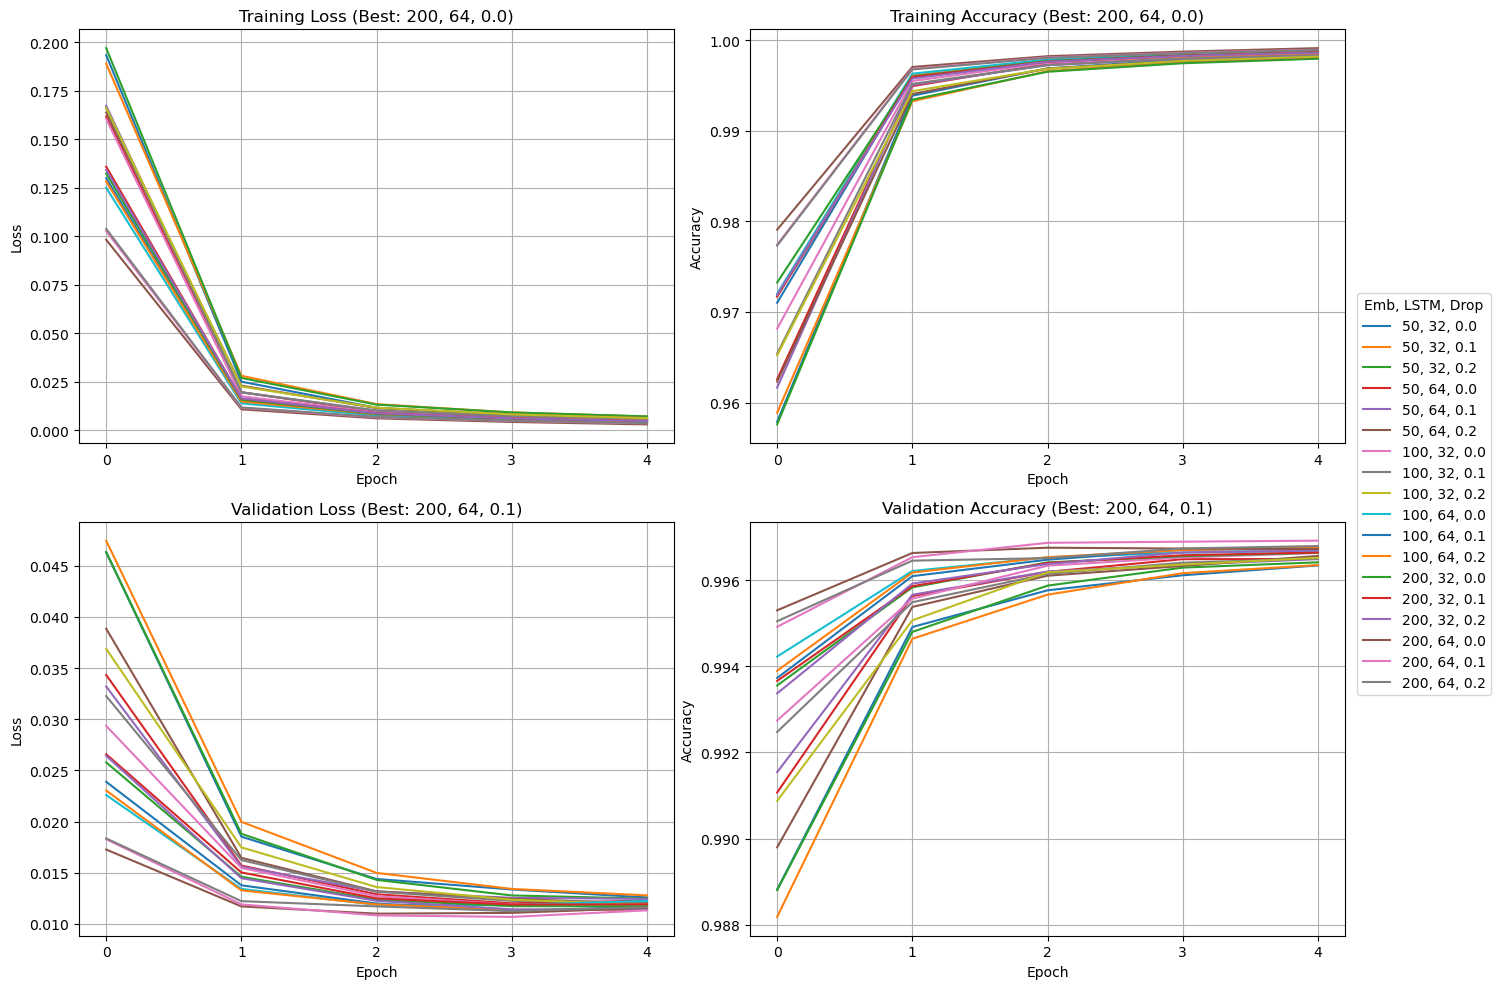

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training loss
for i in range(len(acc_loss_df)):
    axes[0, 0].plot(
        acc_loss_df.iloc[i]["Loss"],
        label=f"{acc_loss_df.iloc[i]['Embedding Dim']}, {acc_loss_df.iloc[i]['LSTM Units']}, {acc_loss_df.iloc[i]['Dropout']}",
    )

best_train_loss = acc_loss_df.loc[acc_loss_df["Loss"].apply(lambda x: x[-1]).idxmin()]
axes[0, 0].set_title(
    f"Training Loss (Best: {best_train_loss['Embedding Dim']}, {best_train_loss['LSTM Units']}, {best_train_loss['Dropout']})"
)
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_xticks(range(5))
axes[0, 0].set_ylabel("Loss")
axes[0, 0].grid()

# Plot training accuracy
for i in range(len(acc_loss_df)):
    axes[0, 1].plot(
        acc_loss_df.iloc[i]["Accuracy"],
        label=f"{acc_loss_df.iloc[i]['Embedding Dim']}, {acc_loss_df.iloc[i]['LSTM Units']}, {acc_loss_df.iloc[i]['Dropout']}",
    )

best_train_acc = acc_loss_df.loc[
    acc_loss_df["Accuracy"].apply(lambda x: x[-1]).idxmax()
]
axes[0, 1].set_title(
    f"Training Accuracy (Best: {best_train_acc['Embedding Dim']}, {best_train_acc['LSTM Units']}, {best_train_acc['Dropout']})"
)
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_xticks(range(5))
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].grid()

# Plot validation loss
for i in range(len(acc_loss_df)):
    axes[1, 0].plot(
        acc_loss_df.iloc[i]["Val Loss"],
        label=f"{acc_loss_df.iloc[i]['Embedding Dim']}, {acc_loss_df.iloc[i]['LSTM Units']}, {acc_loss_df.iloc[i]['Dropout']}",
    )

best_val_loss = acc_loss_df.loc[acc_loss_df["Val Loss"].apply(lambda x: x[-1]).idxmin()]
axes[1, 0].set_title(
    f"Validation Loss (Best: {best_val_loss['Embedding Dim']}, {best_val_loss['LSTM Units']}, {best_val_loss['Dropout']})"
)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_xticks(range(5))
axes[1, 0].set_ylabel("Loss")
axes[1, 0].grid()

# Plot validation accuracy
for i in range(len(acc_loss_df)):
    axes[1, 1].plot(
        acc_loss_df.iloc[i]["Val Accuracy"],
        label=f"{acc_loss_df.iloc[i]['Embedding Dim']}, {acc_loss_df.iloc[i]['LSTM Units']}, {acc_loss_df.iloc[i]['Dropout']}",
    )

best_val_acc = acc_loss_df.loc[
    acc_loss_df["Val Accuracy"].apply(lambda x: x[-1]).idxmax()
]
axes[1, 1].set_title(
    f"Validation Accuracy (Best: {best_val_acc['Embedding Dim']}, {best_val_acc['LSTM Units']}, {best_val_acc['Dropout']})"
)
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_xticks(range(5))
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].grid()

handles, labels = axes[0, 0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.figlegend(
    unique_labels.values(),
    unique_labels.keys(),
    loc="center right",
    title="Emb, LSTM, Drop",
)
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

Conforme os resultados acima, o modelo a ser usado nas predições e testes é o com Embedding = 200, LSTM Units = 64 e Dropout = 0.1.

# Predição e Métricas

In [66]:
def flatten(list_of_lists):
    """
    Converte uma lista de listas em uma única lista achatada.

    Args:
        list_of_lists (list of lists): A lista de listas a ser achatada.

    Returns:
        list: Uma única lista contendo todos os elementos das sublistas.
    """
    return [val for sublist in list_of_lists for val in sublist]


def predict(X_test, y_test_int_unpadded, model):
    """
    Faz a predição

    Args:
        X_test (list of list of int): As sequências de entrada para teste.
        y_test_int_unpadded (list of list of int): As etiquetas verdadeiras para as sequências de teste, sem padding.
        model (keras.Model): O modelo treinado usado para fazer as predições.
    Returns:
        tuple: Uma tupla contendo:
            - y_pred (list of int): As etiquetas preditas.
            - y_real (list of int): As etiquetas verdadeiras.
    """
    test_lengths = []
    for sentence in X_test:
        test_lengths.append(len(sentence))

    test_probs = model.predict(X_test_int)  # N x T x K
    test_predictions = []
    for probs, length in zip(test_probs, test_lengths):
        # probs is T x K
        probs_ = probs[-length:]
        preds = np.argmax(probs_, axis=1)
        test_predictions.append(preds)

    # flatten
    y_pred = flatten(test_predictions)
    y_real = flatten(y_test_int_unpadded)

    return y_pred, y_real

In [ ]:
best = (
    best_val_acc["Embedding Dim"],
    best_val_acc["LSTM Units"],
    best_val_acc["Dropout"],
)
model_path = f"models/BLSTM_{best[0]}_{best[1]}_{best[2]}.h5"
model = build_model(**model_params)

if Path(model_path).exists():
    # Os pesos do modelo estão salvo num arquivo .h5
    model.load_weights(model_path)

else:
    # Se o arquivo com os pesos não existir, vai fazer um novo treino
    h = model.fit(
        X_train_int,
        y_train_int,
        epochs=5,
        validation_data=(X_val_int, y_val_int),
        verbose=True,
    )
    model.save_weights(model_path)

y_pred, y_real = predict(X_test, y_test_int_unpadded, model)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 248)]             0         
                                                                 
 embedding_18 (Embedding)    (None, 248, 200)          10552200  
                                                                 
 bidirectional_18 (Bidirecti  (None, 248, 128)         135680    
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 248, 27)           3483      
                                                                 
Total params: 10,691,363
Trainable params: 10,691,363
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 17s 48ms/step


Resumo dos `Precision Scores`, `Recall Scores` e `F1 Scores` a partir da predição feita sobre os dados de testes.

In [68]:
target_names = list(tag2index.keys())
print(
    classification_report(
        y_real, y_pred, zero_division=np.nan, target_names=[""] + target_names
    )
)
report_dict = classification_report(
    y_real,
    y_pred,
    zero_division=np.nan,
    target_names=[""] + target_names,
    output_dict=True,
)

              precision    recall  f1-score   support

                   0.00       nan      0.00         0
           N       0.91      0.96      0.93     36542
          PU       1.00      1.00      1.00     26904
           V       0.97      0.95      0.96     19711
       NPROP       0.95      0.85      0.89     15936
        PREP       0.95      0.98      0.96     16778
         ART       0.97      0.99      0.98     12580
    PREP+ART       0.98      0.99      0.99     10219
         ADJ       0.89      0.89      0.89      8554
         ADV       0.91      0.86      0.89      5446
          KC       0.96      0.98      0.97      4531
         PCP       0.94      0.84      0.89      3640
         NUM       0.96      0.91      0.93      2541
      PROADJ       0.94      0.96      0.95      3419
          KS       0.86      0.82      0.84      2538
      PRO-KS       0.83      0.92      0.87      2195
     PROPESS       0.98      0.96      0.97      2876
      PROSUB       0.88    

In [69]:
df = pd.DataFrame(report_dict).transpose()
df = df.dropna(axis=0)
df.index.name = "tag"
df["support"] = df["support"].astype(int)
df

,precision,recall,f1-score,support
tag,,,,
N,0.905707,0.964151,0.934016,36542
PU,0.999443,0.999740,0.999591,26904
V,0.974574,0.950890,0.962586,19711
NPROP,0.945150,0.845570,0.892591,15936
PREP,0.954890,0.975265,0.964970,16778
ART,0.966537,0.989587,0.977926,12580
PREP+ART,0.978752,0.991682,0.985175,10219
ADJ,0.888003,0.885200,0.886599,8554
ADV,0.914202,0.862835,0.887776,5446


Esse modelo tem cerca de `94.57%` de acurácia, os valores de precisão, revocação e f1 apresentam variações de acordo com o Tag.

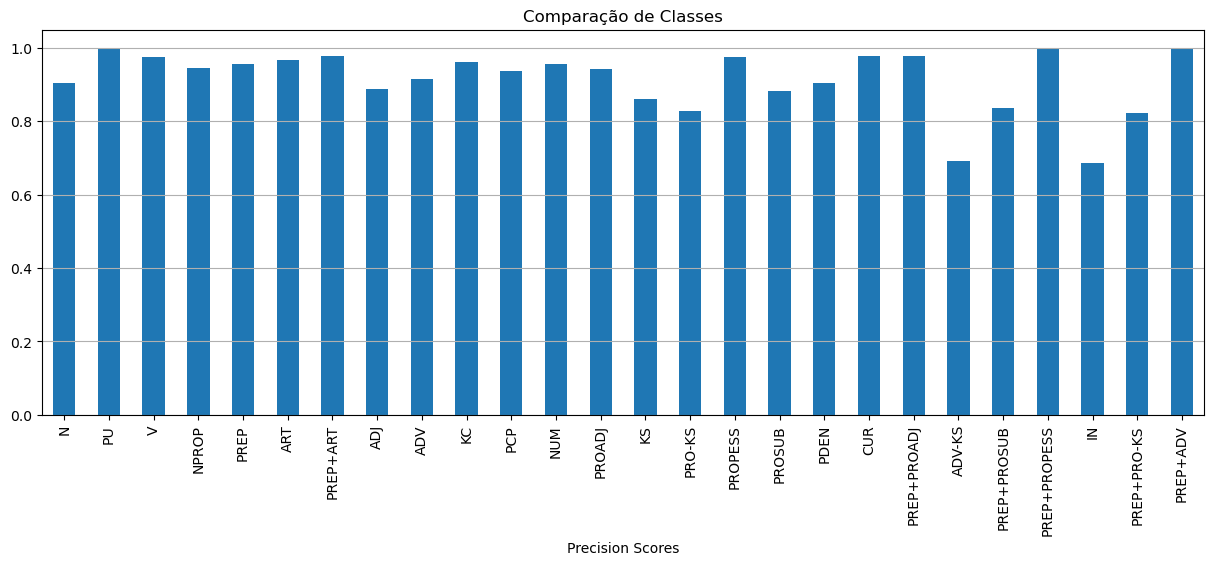

In [88]:
fig, ax = plt.subplots(figsize=(15, 5))
pre_scores = df["precision"].drop(index=["weighted avg", "macro avg", "accuracy"])
pre_scores.plot.bar()
ax.set_xlabel("Precision Scores")
ax.set_title("Comparação de Classes")
plt.grid(axis="y")
plt.show()

Em termos de precisão, temos as tags `IN` (Interjeição) , `ADV-KS` (Advérbio Conectivo Subordinativo) abaixo de 70%, `PREP+PROSUB` (Preposição + Pronome Substantivo) e `PRO-KS` (Pronome Conectivo Subordinativo) e `PREP+PRO-KS` pouco acima de 80%, enquanto os outros têm cerca de 90% ou mais. 

A Interjeição teve o pior resultado geral com 68.8% de precisão. Mas no geral teve bom desempenho com cerca de 94.6% de precisão média.

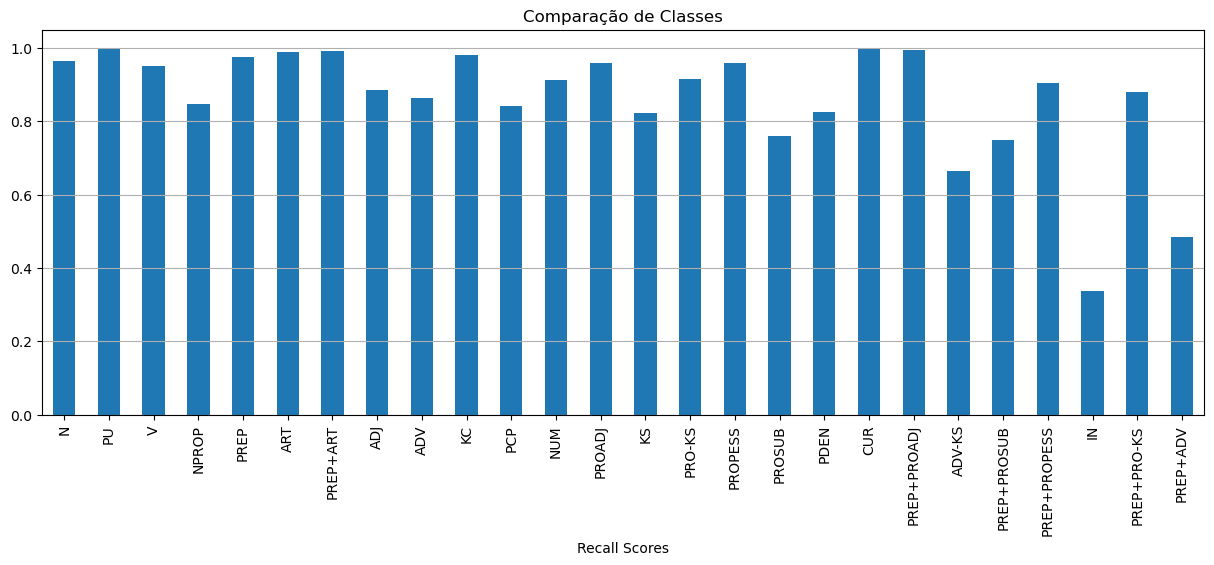

In [91]:
fig, ax = plt.subplots(figsize=(15, 5))
rec_scores = df["recall"].drop(index=["weighted avg", "macro avg", "accuracy"])
rec_scores.plot.bar()
ax.set_xlabel("Recall Scores")
ax.set_title("Comparação de Classes")
plt.grid(axis="y")
plt.show()

A Revocação em geral segue a precisão, com `IN` e `ADV-KS` também tendo valores baixos, porém algumas tags mostraram scores piores, particulamente `PREP+ADV` (Preposição + Advérbio)e `PREP+PROSUB` (Preposição + Pronome Substantivo), duas tags com baixa quantidade de palavras (31 e 156), o que indica um número relativamente grande de Falsos Negativos, não vistos na precisão. `PROSUB`, embora tenha um relativo alto número de ocorrências (1567) também teve uma piora na revocação em relação à precisão.

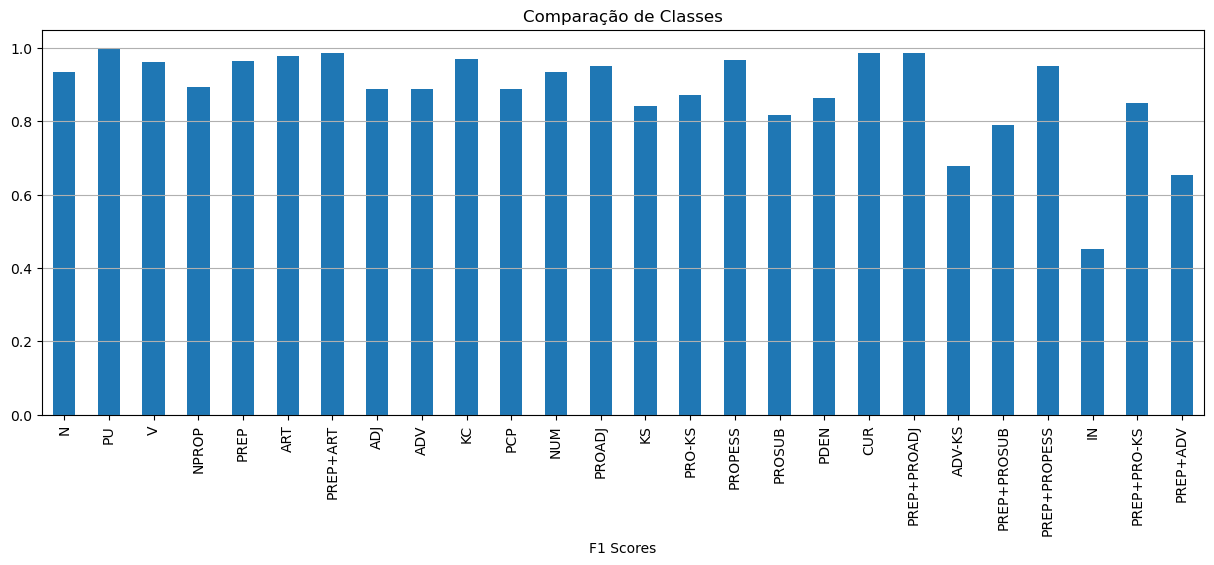

In [92]:
fig, ax = plt.subplots(figsize=(15, 5))
f1_scores = df["f1-score"].drop(index=["weighted avg", "macro avg", "accuracy"])
f1_scores.plot.bar()
ax.set_xlabel("F1 Scores")
ax.set_title("Comparação de Classes")
plt.grid(axis="y")
plt.show()

O F1 Score, sendo uma média dos dois anteriores, segue os valores dos anteriores, pois não houve grande diferença entre a Precisão e Revocação

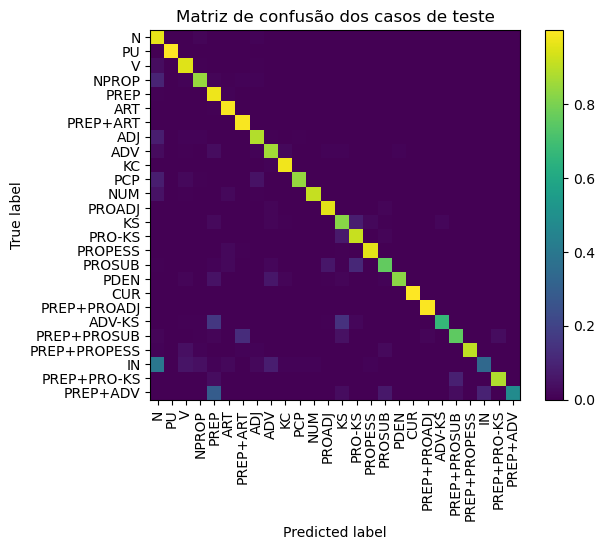

In [74]:
cm = confusion_matrix(y_real, y_pred, normalize="true")
cm = cm[1:, 1:]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=90, include_values=False)
plt.title("Matriz de confusão dos casos de teste")
plt.show()

Podemos ver alguns pontos visíveis de erro, como um número significante de `IN` sendo preditos como `N` (Nome), ou `PREP+ADV` sendo preditos como `PREP`.

# Exemplo de Predição

In [75]:
test_text = [
    "É deitado em uma bela rede que Dorival Caymmi surge como cover boy o novo comercial do Itaú .",
    "Caymmi deixou escapar nos bastidores que não gostava muito de rede .",
    "Mas que fazia bem para o marketing da preguiça .",
    "Que faz bem para seu bolso .",
]

texts_as_ints = word_tokenizer.texts_to_sequences(test_text)
texts_as_ints = pad_sequences(texts_as_ints, maxlen=max_sequence_length)
probs = model.predict(np.asarray(texts_as_ints))

1/1 [==============================] - 0s 49ms/step


In [76]:
outputs = []

for i in range(len(texts_as_ints)):
    sentOutput = []
    for j, prob in enumerate(probs[i]):
        tag = tag_tokenizer.index_word.get(np.argmax(prob), "UNK")
        id = texts_as_ints[i][j]
        if id != 0:
            sentOutput.append((word_tokenizer.index_word[id], tag))
    outputs.append(sentOutput)

for output in outputs:
    print(output)

[('É', 'V'), ('deitado', 'PCP'), ('em', 'PREP'), ('uma', 'ART'), ('bela', 'ADJ'), ('rede', 'N'), ('que', 'PRO-KS'), ('Dorival', 'NPROP'), ('Caymmi', 'NPROP'), ('surge', 'V'), ('como', 'KS'), ('UNK', 'N'), ('UNK', 'V'), ('o', 'ART'), ('novo', 'ADJ'), ('comercial', 'N'), ('do', 'PREP+ART'), ('Itaú', 'NPROP'), ('.', 'PU')]
[('Caymmi', 'NPROP'), ('deixou', 'V'), ('escapar', 'V'), ('nos', 'PREP+ART'), ('bastidores', 'N'), ('que', 'PRO-KS'), ('não', 'ADV'), ('gostava', 'V'), ('muito', 'ADV'), ('de', 'PREP'), ('rede', 'N'), ('.', 'PU')]
[('Mas', 'KC'), ('que', 'KS'), ('fazia', 'V'), ('bem', 'ADV'), ('para', 'PREP'), ('o', 'ART'), ('marketing', 'N'), ('da', 'PREP+ART'), ('preguiça', 'N'), ('.', 'PU')]
[('Que', 'PRO-KS'), ('faz', 'V'), ('bem', 'ADV'), ('para', 'PREP'), ('seu', 'PROADJ'), ('bolso', 'N'), ('.', 'PU')]
